In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
# Load the data from the uploaded CSV file
file_path = "Tesla Stock Price (2010 to 2023).csv"
stock_data = pd.read_csv(file_path)

# Convert 'Date' column to datetime and set it as the index
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

/tmp/ipython-input-285023882.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])


In [7]:
# Filter data for the date range: September 30, 2021, to September 29, 2022
start_date = '2021-09-30'
end_date = '2022-09-29'
stock_data = stock_data.loc[start_date:end_date]

In [8]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,300.295542,307.656601,292.253823,299.864947,299.864947,8.058207e+07
std,46.161120,46.804121,44.718813,45.812123,45.812123,2.549115e+07
min,207.949997,217.973328,206.856674,209.386673,209.386673,3.504270e+07
25%,266.860824,273.241661,260.780823,267.203331,267.203331,6.242468e+07
50%,298.750000,304.158325,289.565002,296.856658,296.856658,7.710210e+07
75%,335.700004,344.957512,327.908341,336.472504,336.472504,9.351338e+07
max,411.470001,414.496674,405.666656,409.970001,409.970001,1.885563e+08


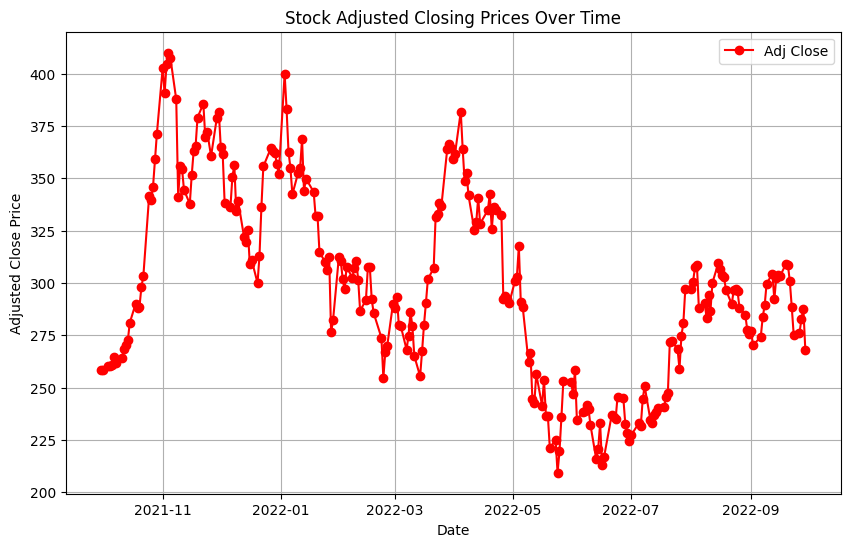

In [9]:
# Assuming stock_data already exists with multiple features
# Select only 'Date' and 'Adj Close' columns
stock_data_adj_close = stock_data[['Adj Close']]

# Plot the 'Adj Close' column over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(stock_data_adj_close.index, stock_data_adj_close['Adj Close'], marker='o', color='r', label='Adj Close')
plt.title('Stock Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Drop columns that aren't needed for prediction
stock_data = stock_data.drop(['Adj Close'], axis=1, errors='ignore')

# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

In [11]:
# Create the training data (70% of the data for training)
training_data_len = int(np.ceil(len(scaled_data) * 0.7))
train_data = scaled_data[0:training_data_len]

In [12]:
# Function to create dataset for LSTM model
def create_dataset(data, time_step=60):
    x_data, y_data = [], []
    for i in range(time_step, len(data)):
        x_data.append(data[i - time_step:i, 0])
        y_data.append(data[i, 0])
    return np.array(x_data), np.array(y_data)

In [13]:
time_step = 60  # Number of previous days to use for predicting the next day
x_train, y_train = create_dataset(train_data, time_step)

# Reshape data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer for stock price prediction

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0107
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0111
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0107
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0110
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0096
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0118
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0104
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0115
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0146
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0137
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0106
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0105
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0116
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0113
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0092
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━

In [22]:
# Create the test dataset (remaining 30% of the data)
test_data = scaled_data[training_data_len - time_step:, :]
x_test, y_test = create_dataset(test_data, time_step)

In [23]:
# Reshape data for LSTM input
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling for the predicted data

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [25]:
# # Calculate RMSE and R² Score

# Reshape y_test to 2D to match the scaler's expected input
y_test_reshaped = y_test.reshape(-1, 1)
y_test_unscaled = scaler.inverse_transform(y_test_reshaped)

# Now compute metrics
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
r2 = r2_score(y_test_unscaled, predictions)

print(f"Fixed RMSE: {rmse}")
print(f"Fixed R² Score: {r2}")

Fixed RMSE: 11.611753598329647
Fixed R² Score: 0.8353147525242782


/tmp/ipython-input-367772152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


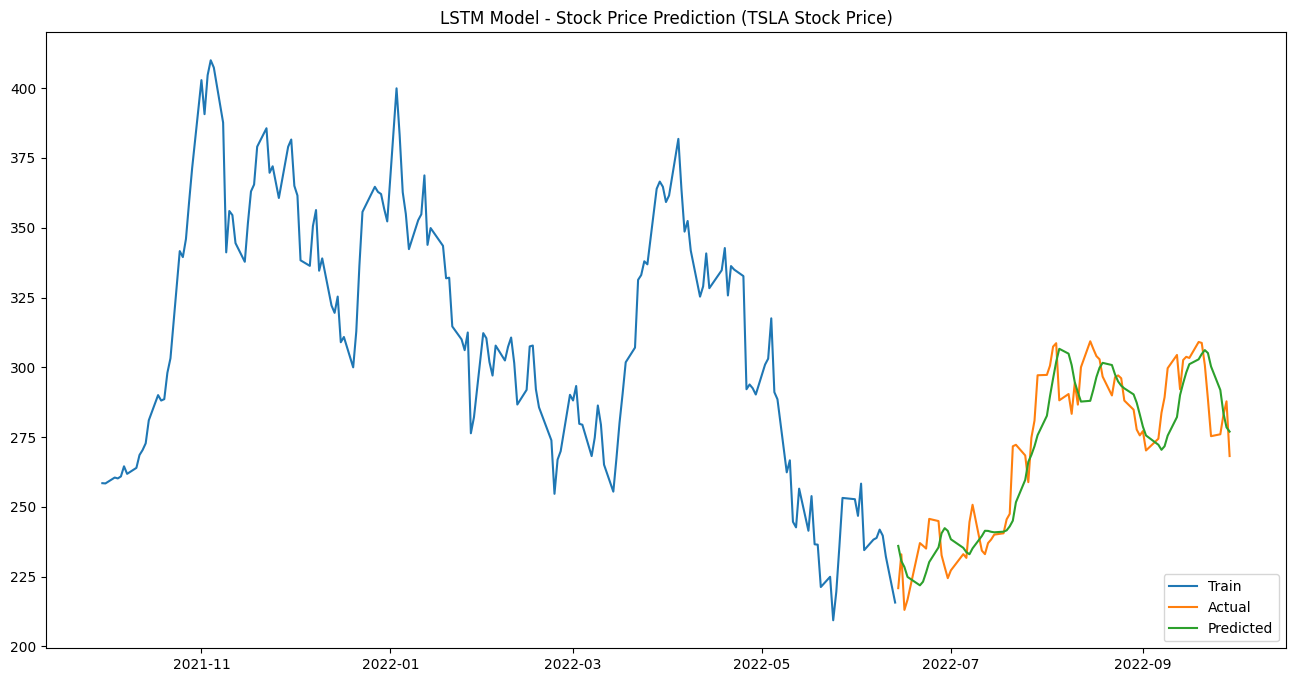

In [26]:
# Plot the predictions and actual prices
train = stock_data[:training_data_len]
valid = stock_data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM Model - Stock Price Prediction (TSLA Stock Price)')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predicted')
plt.legend(loc='lower right')
plt.show()

In [27]:
# Get the dates from the 'valid' DataFrame
prediction_dates = valid.index[-len(predictions):]

# Print the prediction dates
print(prediction_dates)

DatetimeIndex(['2022-06-14', '2022-06-15', '2022-06-16', '2022-06-17',
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24',
               '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30',
               '2022-07-01', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12', '2022-08-15', '2022-08-16',
               '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-22',
               '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26',
               '2022-08-29', '2022-08-30', '2022-08-31', '2022-09-01',
      

In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from transformers import pipeline
from datetime import datetime

In [29]:
# Load stock data (filtered for Sep 30, 2021 to Sep 29, 2022)
file_path_stock = "Tesla Stock Price (2010 to 2023).csv"
stock_data = pd.read_csv(file_path_stock)
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date  # Ensure date format is compatible
stock_data = stock_data[(stock_data['Date'] >= datetime.strptime("2021-09-30", "%Y-%m-%d").date()) &
                        (stock_data['Date'] <= datetime.strptime("2022-09-29", "%Y-%m-%d").date())]

/tmp/ipython-input-2993853749.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date  # Ensure date format is compatible


In [30]:
# Load tweet data
file_path_tweets = "formatted_stock_tweets.csv"
tweet_data = pd.read_csv(file_path_tweets)
tweet_data['Date'] = pd.to_datetime(tweet_data['Date']).dt.date  # Ensure date format is compatible

In [31]:
# Initialize BERT sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [32]:
# Have tweet_data DataFrame with a 'Tweet' column and sentiment_analyzer is a function that returns
# sentiment score in the form [{'label': 'POSITIVE', 'score': 0.95}]

# Apply BERT sentiment analysis to each tweet and store the sentiment score
tweet_data['Sentiment_Score'] = tweet_data['Tweet'].apply(lambda x: sentiment_analyzer(x)[0]['score'])

# Save the DataFrame with the new 'Sentiment_Score' column to a new CSV file
output_file = 'tweets_with_sentiment.csv'
tweet_data.to_csv(output_file, index=False)

print(f"CSV file '{output_file}' has been created with sentiment scores.")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


CSV file 'tweets_with_sentiment.csv' has been created with sentiment scores.


In [33]:
# Calculate daily average sentiment score
daily_sentiment = tweet_data.groupby('Date')['Sentiment_Score'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Average_Sentiment']

In [34]:
tweet_data.head()
# tweet_data.tail()

,Date,Tweet,Stock Name,Company Name,is_relevant,has_emoji,Sentiment_Score
0,2021-10-27,$tsla just the beginning https://t.co/cqDNwwMFUT,TSLA,"Tesla, Inc.",True,False,0.272163
1,2022-08-18,Congrats @Tesla on this huge accomplishment! @...,TSLA,"Tesla, Inc.",True,False,0.800708
2,2021-12-20,30 out of 30 equity analyst covering $amzn rat...,PG,Procter & Gamble Company,True,False,0.556097
3,2022-03-21,Multiple sources have informed me that Wardell...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,True,False,0.296502
4,2022-01-10,"$GOOG is trading at &lt;22x LTM, likely &lt;18...",GOOG,Alphabet Inc.,True,False,0.475921


In [35]:
tweet_data.describe()

,Sentiment_Score
count,10000.000000
mean,0.465170
std,0.156575
min,0.208398
25%,0.339712
50%,0.438982
75%,0.567560
max,0.974148


In [36]:
# Convert 'Date' column in daily_sentiment to datetime
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Now filter for matching dates
matching_sentiment = daily_sentiment[daily_sentiment['Date'].isin(prediction_dates)]

# Select only the 'Average_Sentiment' column for these dates
average_sentiments_for_prediction_dates = matching_sentiment['Average_Sentiment']

In [189]:
# import pandas as pd

# # Apply the sentiment score multiplier
# alpha = 0.1  # Adjust the alpha value as needed
# sentiment_multiplier = 1 + alpha * (average_sentiments_for_prediction_dates - 0.5)#0.465170

# # Convert predictions to a Series with the same index as sentiment_multiplier
# predictions_series = pd.Series(predictions.flatten(), index=average_sentiments_for_prediction_dates.index)

# # Perform element-wise multiplication
# adjusted_predictions = predictions_series * sentiment_multiplier
# Set threshold and alpha
threshold = 0.1 # Neutral band around 0.5 → apply only if score < 0.45 or > 0.55
alpha = 0.2

# Calculate sentiment multiplier only for confident scores
sentiment_scores = average_sentiments_for_prediction_dates

# Apply multiplier conditionally
sentiment_multiplier = []
for score in sentiment_scores:
    if score < (0.5 - threshold) or score > (0.5 + threshold):
        multiplier = 1 + alpha * (score - 0.5)
    else:
        multiplier = 1  # No adjustment
    sentiment_multiplier.append(multiplier)

# Apply multiplier to predictions
predictions_series = pd.Series(predictions.flatten(), index=average_sentiments_for_prediction_dates.index)
adjusted_predictions = predictions_series * sentiment_multiplier

In [190]:
print(adjusted_predictions)

257    236.024200
258    230.614685
259    222.996166
260    224.910187
264    221.904572
          ...    
358    300.309937
361    291.873718
362    283.600525
363    278.486237
364    276.963928
Length: 75, dtype: float64


In [191]:
# Convert adjusted_predictions to DataFrame
adjusted_predictions_df = pd.DataFrame(adjusted_predictions, columns=['Predictions'])

# Add the 'Date' column
adjusted_predictions_df['Date'] = matching_sentiment['Date'].values

# Set 'Date' as the index
adjusted_predictions_df.set_index('Date', inplace=True)

In [153]:
# # Make sure y_test_unscaled and adjusted_predictions are numpy arrays
# adjusted_predictions = adjusted_predictions.values.flatten()

# # Create a clean copy of valid (make sure it matches prediction length)
# valid = stock_data[training_data_len:].copy()
# valid = valid.iloc[-len(adjusted_predictions):]  # Align size with predictions

# # Add predictions to valid
# valid['Predictions'] = adjusted_predictions

# # Plot
# plt.figure(figsize=(16,8))
# plt.title('LSTM Model - Stock Price Prediction with Sentiment Analysis using BERT')
# plt.plot(train['Close'], label='Train')
# plt.plot(valid['Close'], label='Actual')
# plt.plot(valid['Predictions'], label='Predicted (Sentiment Adjusted)')
# plt.legend(loc='lower right')
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Stock data index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


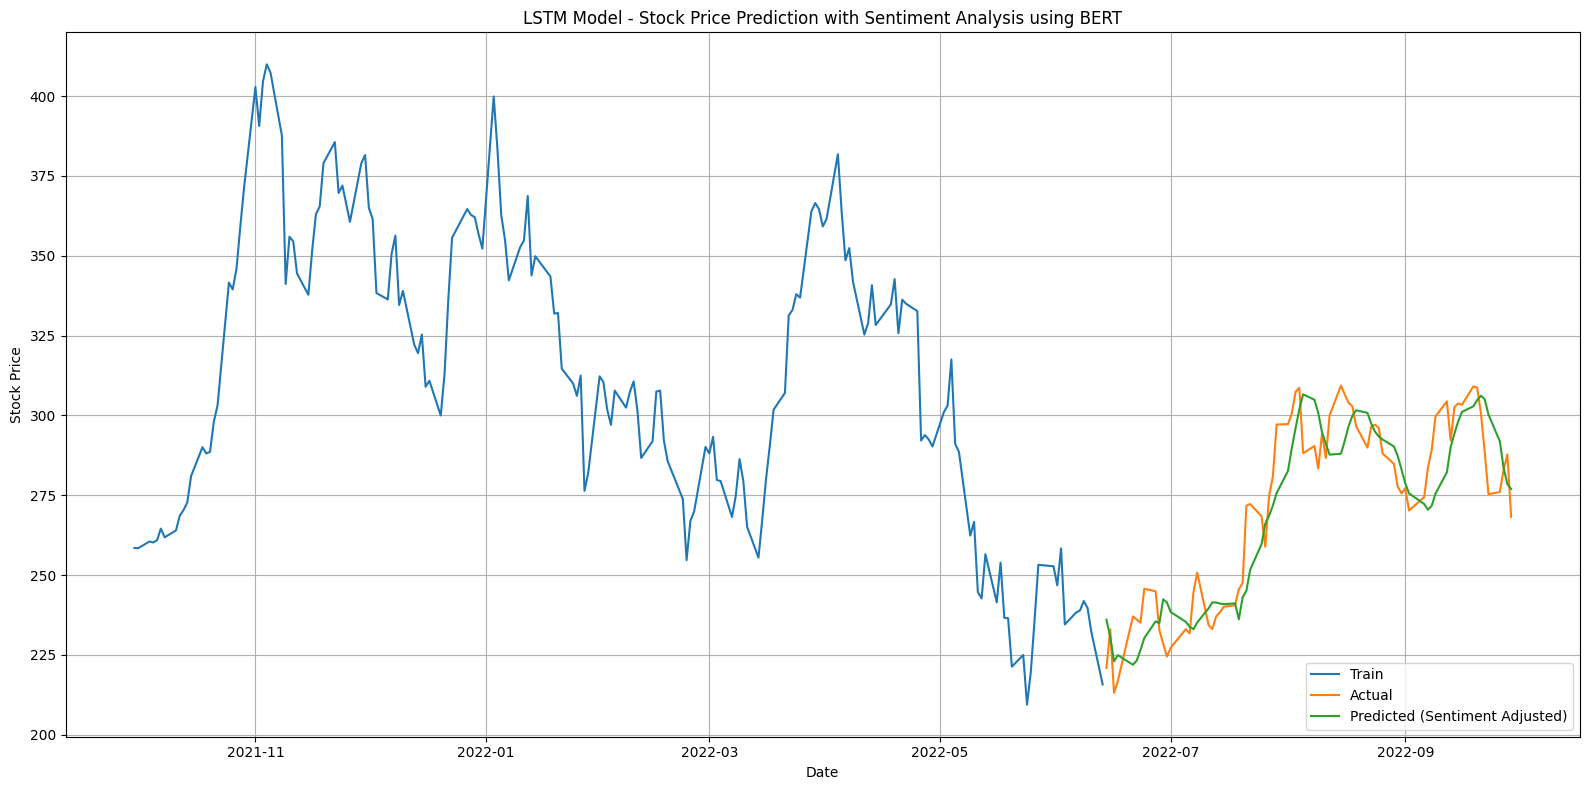

In [192]:
# 1. Ensure Date column is datetime if it's a column (not index)
if 'Date' in stock_data.columns:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
else:
    stock_data.index = pd.to_datetime(stock_data.index)

# 2. Sanity check
print("Stock data index type:", type(stock_data.index[0]))  # Should be <class 'pandas._libs.tslibs.timestamps.Timestamp'>

# 3. Split into training and validation
train = stock_data.iloc[:training_data_len].copy()     # Should preserve datetime index
valid = stock_data.iloc[training_data_len:].copy().reset_index()  # Will reset index for merging

# 4. Ensure all date columns are datetime
valid['Date'] = pd.to_datetime(valid['Date'])
adjusted_predictions_df = adjusted_predictions_df.reset_index()
adjusted_predictions_df['Date'] = pd.to_datetime(adjusted_predictions_df['Date'])

# 5. Merge predictions into valid
valid = pd.merge(valid, adjusted_predictions_df, on='Date', how='inner')
valid.set_index('Date', inplace=True)

# 6. Final plot
plt.figure(figsize=(16,8))
plt.title('LSTM Model - Stock Price Prediction with Sentiment Analysis using BERT')
plt.plot(train['Close'], label='Train')                        # This should now be correct
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predicted (Sentiment Adjusted)')
plt.legend(loc='lower right')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [193]:
# Unscale y_test before evaluating
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate using adjusted predictions
rmse = np.sqrt(mean_squared_error(y_test_unscaled, adjusted_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test_unscaled, adjusted_predictions)
print(f"R² Score: {r2}")

Root Mean Squared Error (RMSE): 11.541448580043221
R² Score: 0.8373029360157602
